## QSPRpred

QSPRpred is primarily a tool for QSPR modelling of small molecules, but we are trying to make it rather versatile and also use it for simple management of chemical data. It could also be generalized to work with other entities like proteins in a similar fashion. PCM modelling is already included so to some extent that support is already there. The main idea of QSPRpred is to help with the following tasks:

- data management (rich metadata and clear structure of Python objects that are automatically mapped to data storage formats)
- research reproducibility (centralized random seed management and self-contained portable pipelines via its API)
- software accessibility (easy-to-use)
- tool and data interoperability (defines clear standards, but also supports commonly used formats for the exchange of data -> i.e. `pandas`)

Overall, the [FAIR principles](https://www.nature.com/articles/s41597-022-01710-x) are the core inspiration behind the frameowork.

## Spock

Spock is simply an extension of the data management tools QSPRpred offers applied to structure-based drug design. In this short demonstration, we will show the core principles of Spock and QSPRpred for this task.

## Representing Data Sets

QSPRpred defines an API to store molecules:

In [63]:
from qsprpred.data.storage.tabular.simple import PandasChemStore
from qsprpred.data.chem.identifiers import InchiIdentifier
from qsprpred.data.chem.standardizers.papyrus import PapyrusStandardizer
import pandas as pd
import shutil
import os

# List of directories to remove
directories_to_remove = ['./data/SpockStorage', './data/ChemStorage', './data/ProtomerStorage']

for directory in directories_to_remove:
    if os.path.exists(directory):
        shutil.rmtree(directory)

## Create a library of compounds stored as a pandas data frame
library = PandasChemStore(
    name="ChemStorage",
    path="./data/",
    df=pd.read_csv("subset.csv"),
    standardizer=PapyrusStandardizer(),
    identifier=InchiIdentifier(),
)
len(library)

2

In [64]:
for mol in library:
    # Initialize mol without printing anything
    mol.as_rd_mol()  # Ensure the method is called to initialize properly if needed
    break

In [ ]:
for mol in library:
    print(mol.id)
    print(mol.props)
    display(mol.as_rd_mol()) # interoperable with RDKit
    break

In [ ]:
library["NOONHGWVUPDPFR-RNFRBKRXSA-N"].as_rd_mol() # Pythonic and data storage agnostic API

In [ ]:
search_result = library.searchWithSMARTS(["[ar]1[ar][ar][ar][ar][ar]1"])
len(search_result)

In [ ]:
type(search_result)

In [ ]:
search_result.getDF() # interoperable

In [ ]:
from qsprpred.plotting.grid_visualizers import table_to_grid

table_to_grid(search_result)

In [ ]:
library.standardizer.getID() # rich metadata

In [ ]:
library.toJSON()

In [ ]:
library.save()

In [ ]:
library.metaFile

In [ ]:
len(PandasChemStore.fromFile(library.metaFile)) # metadata directly facilitates interoperability (portable JSON format describes each instance)

## Creating Molecular Representations

Sometimes we need to represent more states/representations of a molecule (i.e. protomers, conformers or mutants in case of proteins). We can just create another storage for that:

In [65]:
from qsprpred.data.storage.tabular.hierarchical import PandasRepresentationStore
from spock.prep import Dimorphite # generates protomers of molecules

## make a storage for protomers of molecules in our library
representation_store = PandasRepresentationStore(
    name="ProtomerStorage",
    path="./data/",
    chem_store=library, # our library from before (interoperable between packages that adhere to its defined API)
)
dm = Dimorphite(ph_range=(7,7.5), max_variants=5)
dm.apply_to_storage(representation_store)

/Users/jelle/miniconda3/envs/spock/lib/python3.12/site-packages/qsprpred/data/tables/pandas.py:768: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  self.df = pd.concat([


In [ ]:
for mol in representation_store:
    if mol.representations and len(mol.representations) > 1:
        print(mol.representations)
        break

In [66]:
for mol in representation_store:
    if mol.representations and len(mol.representations) > 1:
        break

In [ ]:
mol.representations[0].as_rd_mol()

In [ ]:
mol.representations[1].as_rd_mol()

In [ ]:
mol

In [ ]:
mol.representations[0].parent

In [ ]:
print(mol.representations[0].representations)

In [ ]:
mol.id

## Storing Docking Results with Spock

Let's just create another storage...

In [67]:
from spock.storage.tabular import SpockStorage

## Create Spock storage for ligand poses
store = SpockStorage(
    name="SpockStorage",
    path="./data/",
    ligand_store=representation_store,
)

store.getSummary()

Path          Name  Molecules  Targets  Poses
0  ./data/SpockStorage  SpockStorage          2        0      0

In [68]:
from spock.storage.tabular import SpockProtein
from spock.docking.vina.cpu_local import VinaDockingCPULocal
import os

PROTEIN_NAME = "7vhy"  # name of protein
N_CPUS = os.cpu_count()  # number of cpus to use for docking
EXHAUSTIVENESS = 8  # Vina exhaustiveness parameter
SEED = 42  # random seed for random operations
PROTEIN_FOLDER = './data/Receptor'

docking = VinaDockingCPULocal(
    protein=SpockProtein(
        PROTEIN_NAME,
        props={
            "pdb": open(f'{PROTEIN_FOLDER}/{PROTEIN_NAME}.pdb', 'r').read(),
            "pdbqt": open(f'{PROTEIN_FOLDER}/{PROTEIN_NAME}.pdbqt', 'r').read(),
        }
    ),
    n_cpus=N_CPUS,
    box_spec={
        "center": [5.1, 28.0, 187.6],
        "box_size": [16.2, 17.8, 17.4]
    },
    embed_mols=True,  # set to False if conformers are already generated
    exhaustiveness=EXHAUSTIVENESS,
    seed=SEED,
    timeout=60,
)

In [69]:
# do the docking

store.nJobs = N_CPUS # n_cpus can also be set on the storage itself and the docking engine will use it
docking.dock_storage(storage=store, chunk_size=1, save=False, overwrite=True)

/Users/jelle/miniconda3/envs/spock/lib/python3.12/site-packages/meeko/preparation.py:230: DeprecationWarning: MoleculePreparation.write_pdbqt_string() is deprecated in Meeko v0.5. Pass the MoleculeSetup instance to PDBQTWriterLegacy.write_string(). MoleculePreparation.prepare() returns a list of MoleculeSetup instances.
  warnings.warn(msg, DeprecationWarning)
/Users/jelle/miniconda3/envs/spock/lib/python3.12/site-packages/meeko/preparation.py:93: DeprecationWarning: MoleculePreparation.setup is deprecated in Meeko v0.5. MoleculePreparation.prepare() returns a list of MoleculeSetup instances.
  warnings.warn(msg, DeprecationWarning)
/Users/jelle/miniconda3/envs/spock/lib/python3.12/site-packages/meeko/preparation.py:230: DeprecationWarning: MoleculePreparation.write_pdbqt_string() is deprecated in Meeko v0.5. Pass the MoleculeSetup instance to PDBQTWriterLegacy.write_string(). MoleculePreparation.prepare() returns a list of MoleculeSetup instances.
  warnings.warn(msg, DeprecationWarni

Computing Vina grid ... done.
Performing docking (random seed: 42) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
*Computing Vina grid ... done.
Performing docking (random seed: 42) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
****************************************************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1            0          0          0
   2     3.26e-05      3.788      5.444
   3     3.26e-05      4.177      6.823
   4    8.844e-05      6.572      7.856
   5    0.0001183       6.04      8.882
   6    0.0001336      5.511       7.85
   7    0.0001385      4.646      9.704
   8    0.0002888      7.145      9.547
   9    0.0003854      4.574      6.873
  10    0.0004145      3.888      5.055
  11     0.000435      5.285 

/Users/jelle/miniconda3/envs/spock/lib/python3.12/site-packages/qsprpred/data/tables/pandas.py:768: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  self.df = pd.concat([
/Users/jelle/miniconda3/envs/spock/lib/python3.12/site-packages/qsprpred/data/tables/pandas.py:768: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  self.df = pd.concat([


***********************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1            0          0          0
   2    9.547e-05      3.758      7.479
   3     0.000233      7.073      10.14
   4    0.0003537      4.976      6.784
   5      0.00047      5.797      8.787
   6    0.0004963      4.785      7.278
   7    0.0005413      5.918      9.339
   8    0.0006389      4.462      7.411
   9    0.0006447      7.217      11.68
  10     0.000755      4.844      8.677
  11    0.0008388      6.692       9.02
  12    0.0009155      5.937      10.53
  13     0.001041      6.726      7.902
  14     0.001068      5.752      7.694
  15     0.001092      3.224      8.708
  16     0.001098      4.786      7.548
  17     0.001139      4.374      5.508
  18     0.001186      4.127      8.198
  19     0.001243      4.914      7.866
  20     0.001447       5.31      7.533
Docking of 'SpockStorage (SpockStorage)' finished.
Av

In [70]:
store.getSummary()

Path          Name  Molecules  Targets  Poses
0  ./data/SpockStorage  SpockStorage          2        1     81

In [71]:
# naturally we can reload from everything anytime
store.save()
store = SpockStorage.fromFile(store.metaFile)
store.getSummary()

Path          Name  Molecules  Targets  Poses
0  ./data/SpockStorage  SpockStorage          2        1     81

## Showing Results

In [78]:
store.getDF()

ChemStorage_ID  \
SpockStorage_poses_representations_ID                               
SpockStorage_poses_representations_library_2774...           None   
SpockStorage_poses_representations_library_2774...           None   
SpockStorage_poses_representations_library_2774...           None   
SpockStorage_poses_representations_library_2774...           None   
SpockStorage_poses_representations_library_2774...           None   
...                                                           ...   
SpockStorage_poses_representations_library_e1a4...           None   
SpockStorage_poses_representations_library_e1a4...           None   
SpockStorage_poses_representations_library_e1a4...           None   
SpockStorage_poses_representations_library_e1a4...           None   
SpockStorage_poses_representations_library_e1a4...           None   

                                                                                            parent_id  \
SpockStorage_poses_representations_ID                                                                   
SpockStorage_poses_representations_library_2774...  ProtomerStorage_representations_library_555381...   
SpockStorage_poses_representations_library_2774...  ProtomerStorage_representations_library_555381...   
SpockStorage_poses_representations_library_2774...  ProtomerStorage_representations_library_555381...   
SpockStorage_poses_representations_library_2774...  ProtomerStorage_representations_library_555381...   
SpockStorage_poses_representations_library_2774...  ProtomerStorage_representations_library_555381...   
...                                                                                               ...   
SpockStorage_poses_representations_library_e1a4...  ProtomerStorage_representations_library_ad8894...   
SpockStorage_poses_representations_library_e1a4...  ProtomerStorage_representations_library_ad8894...   
SpockStorage_poses_representations_library_e1a4...  ProtomerStorage_representations_library_ad8894...   
SpockStorage_poses_representations_library_e1a4...  ProtomerStorage_representations_library_ad8894...   
SpockStorage_poses_representations_library_e1a4...  ProtomerStorage_representations_library_ad8894...   

                                                                                               SMILES  \
SpockStorage_poses_representations_ID                                                                   
SpockStorage_poses_representations_library_2774...  [H]c1nc([H])c2c(c([H])nn2[H])c1C(=O)N([H])C([H...   
SpockStorage_poses_representations_library_2774...  [H]c1nc([H])c2c(c([H])nn2[H])c1C(=O)N([H])C([H...   
SpockStorage_poses_representations_library_2774...  [H]c1nc([H])c2c(c([H])nn2[H])c1C(=O)N([H])C([H...   
SpockStorage_poses_representations_library_2774...  [H]c1nc([H])c2c(c([H])nn2[H])c1C(=O)N([H])C([H...   
SpockStorage_poses_representations_library_2774...  [H]c1nc([H])c2c(c([H])nn2[H])c1C(=O)N([H])C([H...   
...                                                                                               ...   
SpockStorage_poses_representations_library_e1a4...  [H]c1nn([H])c2c1C([H])(C(=O)N1C([H])([H])C([H]...   
SpockStorage_poses_representations_library_e1a4...  [H]c1nn([H])c2c1C([H])(C(=O)N1C([H])([H])C([H]...   
SpockStorage_poses_representations_library_e1a4...  [H]c1nn([H])c2c1C([H])(C(=O)N1C([H])([H])C([H]...   
SpockStorage_poses_representations_library_e1a4...  [H]c1nn([H])c2c1C([H])(C(=O)N1C([H])([H])C([H]...   
SpockStorage_poses_representations_library_e1a4...  [H]c1nn([H])c2c1C([H])(C(=O)N1C([H])([H])C([H]...   

                                                                                                  sdf  \
SpockStorage_poses_representations_ID                                                                   
SpockStorage_poses_representations_library_2774...  \n     RDKit          3D\n\n 55 58  0  0  0  0...   
SpockStorage_poses_representations_library_2774...  \n     RDKit          3D\n\n 55 58  0  0  0  0...   
S

In [75]:
store.targets[0].id

'7vhy'

In [ ]:
# targets also live in their own storage
store._targets

In [74]:
# with a familiar API
store._targets.getDF()

Sequence accession  \
accession                      
7vhy           NaN      7vhy   

                                                         pdb  \
accession                                                      
7vhy       CRYST1   44.490   88.781   89.949 116.58  99.4...   

                                                       pdbqt  
accession                                                     
7vhy       ATOM      1  N   TYR A1162       3.798 -36.627...

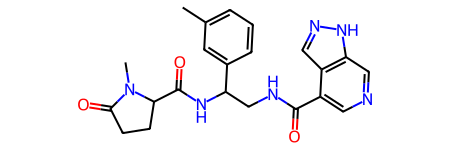

In [72]:
mol.as_rd_mol()

In [73]:
poses = store.get_poses(mol.representations[0].id, target=store.targets[0].id)
poses

[SpockMol(SpockStorage_poses_representations_library_27741e600d314198b8c069336caa8bbe_0, [H]c1nc([H])c2c(c([H])nn2[H])c1C(=O)N([H])C([H])([H])C([H])(c1c([H])c([H])c([H])c(C([H])([H])[H])c1[H])N([H])C(=O)C1([H])N(C([H])([H])[H])C(=O)C([H])([H])C1([H])[H]),
 SpockMol(SpockStorage_poses_representations_library_27741e600d314198b8c069336caa8bbe_1, [H]c1nc([H])c2c(c([H])nn2[H])c1C(=O)N([H])C([H])([H])C([H])(c1c([H])c([H])c([H])c(C([H])([H])[H])c1[H])N([H])C(=O)C1([H])N(C([H])([H])[H])C(=O)C([H])([H])C1([H])[H]),
 SpockMol(SpockStorage_poses_representations_library_27741e600d314198b8c069336caa8bbe_2, [H]c1nc([H])c2c(c([H])nn2[H])c1C(=O)N([H])C([H])([H])C([H])(c1c([H])c([H])c([H])c(C([H])([H])[H])c1[H])N([H])C(=O)C1([H])N(C([H])([H])[H])C(=O)C([H])([H])C1([H])[H]),
 SpockMol(SpockStorage_poses_representations_library_27741e600d314198b8c069336caa8bbe_3, [H]c1nc([H])c2c(c([H])nn2[H])c1C(=O)N([H])C([H])([H])C([H])(c1c([H])c([H])c([H])c(C([H])([H])[H])c1[H])N([H])C(=O)C1([H])N(C([H])([H])[H])C(=O)

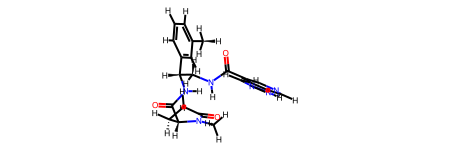

In [79]:
poses[0].as_rd_mol()

In [80]:
import nglview
view = nglview.show_rdkit(poses[0].as_rd_mol())  # load "3pqr" from RCSB PDB and display viewer widget
view

NGLWidget()

In [81]:
poses[0].props

{'SpockStorage_poses_representations_ID_before_change': 'SpockStorage_poses_representations_library_27741e600d314198b8c069336caa8bbe_0',
 'parent_id': 'ProtomerStorage_representations_library_555381f9d031427fa91e1869acd436aa_0',
 'vina_energy_inter': '0.0',
 'ChemStorage_ID': None,
 'original_smiles': '[H]c1nc([H])c2c(c([H])nn2[H])c1C(=O)N([H])C([H])([H])C([H])(c1c([H])c([H])c([H])c(C([H])([H])[H])c1[H])N([H])C(=O)C1([H])N(C([H])([H])[H])C(=O)C([H])([H])C1([H])[H]',
 'vina_energy_torsions': '0.0',
 'sdf': '\n     RDKit          3D\n\n 55 58  0  0  0  0  0  0  0  0999 V2000\n    7.7220   30.3920  185.0650 C   0  0  0  0  0  0  0  0  0  0  0  0\n    6.9900   30.3950  186.3690 C   0  0  0  0  0  0  0  0  0  0  0  0\n    6.4270   31.5830  186.7730 C   0  0  0  0  0  0  0  0  0  0  0  0\n    5.7410   31.6020  187.9860 C   0  0  0  0  0  0  0  0  0  0  0  0\n    5.6510   30.4360  188.7330 C   0  0  0  0  0  0  0  0  0  0  0  0\n    6.2140   29.2590  188.3240 C   0  0  0  0  0  0  0  0  0  0 

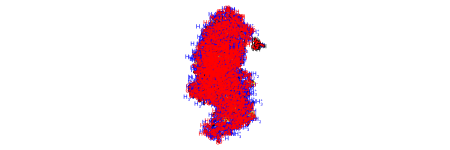

In [82]:
complex = store.get_complex_for_pose(pose_id=poses[0].id)
complex

In [83]:
type(complex)

rdkit.Chem.rdchem.Mol

In [84]:
nglview.show_rdkit(complex)

KekulizeException: Can't kekulize mol.  Unkekulized atoms: 293 294 295 296 297

In [85]:
complex_graph = store.targets[0].graph + poses[0].graph
complex_graph

MolecularGraph: < + > | Nodes: 6983 | Edges: 7174

In [86]:
from graphein.molecule import plotly_molecular_graph

plotly_molecular_graph(complex_graph.nx, colour_nodes_by='entity', colour_edges_by='type')

/Users/jelle/miniconda3/envs/spock/lib/python3.12/site-packages/graphein/protein/config.py:217: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  @validator("alt_locs")


## Analyzing IFPs

Example of connecting this data back to QSPRpred.

In [41]:
from qsprpred.data import MoleculeTable
from qsprpred.data.descriptors.fingerprints import MorganFP
from spock.ml.descriptors import PLIPIFP

mt = MoleculeTable(
    store,
    name="TestMoleculeTable",
    path=store.baseDir,
)
mt.nJobs = os.cpu_count()
mt.chunkSize = 5

In [ ]:
mt.addDescriptors(
    [
        PLIPIFP(store.targets[0], n_poses=2)
    ], recalculate=True
)

In [ ]:
descs = mt.getDescriptors()
descs

In [44]:
mt.addDescriptors([MorganFP(radius=3, nBits=2048)], recalculate=True)

In [ ]:
mt.getDescriptors()